In [1]:
'''
In this notebook we train our model. The thickness and number of hidden layers were tuned manually, 
but otherwise nothing else has. Once could e.g. change the activation function from tanh to relu.

The FunctionScalar package (https://github.com/weissercn/FunctionScaler/) is used to preprocess the data. 
Installing this package can be done using pip (pip install FunctionScaler)
'''

'\nIn this notebook we train our model. The thickness and number of hidden layers were tuned manually, \nbut otherwise nothing else has. Once could e.g. change the activation function from tanh to relu\n'

In [2]:
#Importing necessary libraries
import numpy as np
from keras.layers import Input, Dense, Dropout
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, TensorBoard
from keras import optimizers
from keras import backend as K
import keras

#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
from sklearn import metrics

import math
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
#%matplotlib notebook

import string
plt.rc('text', usetex=False)

import pickle

from Autoencoder_Utils import *
from __future__ import print_function

/usr/local/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using Theano backend.


In [3]:
#Loading the data
TYPE = "" # 100% of the data. To determine the real performance of the cross check
#TYPE = "_10perc" #10% of the data. Used for everything except to determine the real performance of the cross check
#TYPE = "_1perc" #1% of the data. For small tests.
#TYPE = "_100" #100 samples of the data. For very rudimentary tests


df = pd.read_csv('Data/Df_example{}.csv'.format(TYPE))


var_list = list(df)

In [4]:
#How many samples of each particle do we have
print (df['pid'].value_counts())
pids_no = df['pid'].value_counts().to_dict()
n_samples = np.shape(df.as_matrix())[0]

f    454948
e    450775
a    438012
c    408195
d    377725
b    358002
Name: pid, dtype: int64


In [5]:
#Dividing the variables into compressable, auxiliary and simulation truth variables not seen in real datasets
vars_list = list(df)
vars_list_input, vars_list_aux, vars_list_MC = [], [], [] 
for v in vars_list:
    if v=='pid': vars_list_MC.append(v)
    elif 'aux' in v: vars_list_aux.append(v)
    else: vars_list_input.append(v)
print ("{} variables to compress".format(len(vars_list_input)) )

18 variables to compress


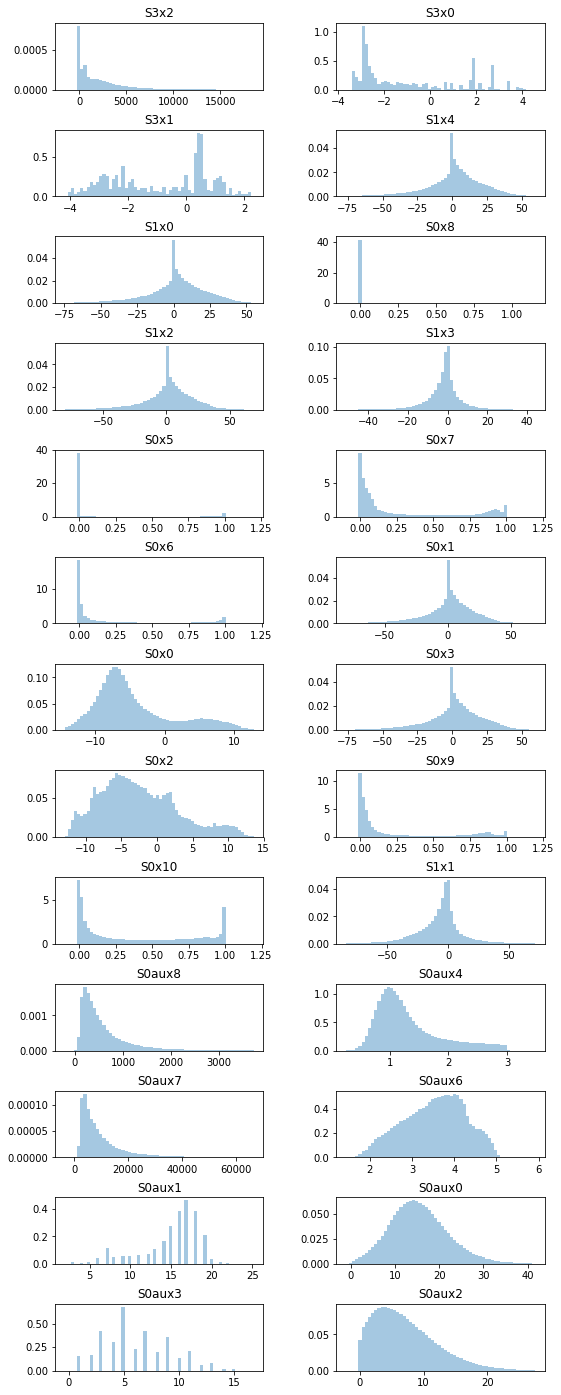

In [6]:
#Display histograms of our features
print_features_histograms(df[vars_list_input+vars_list_aux], None, save_filename="original_distribs.png")

 S C A L E D --- D F 


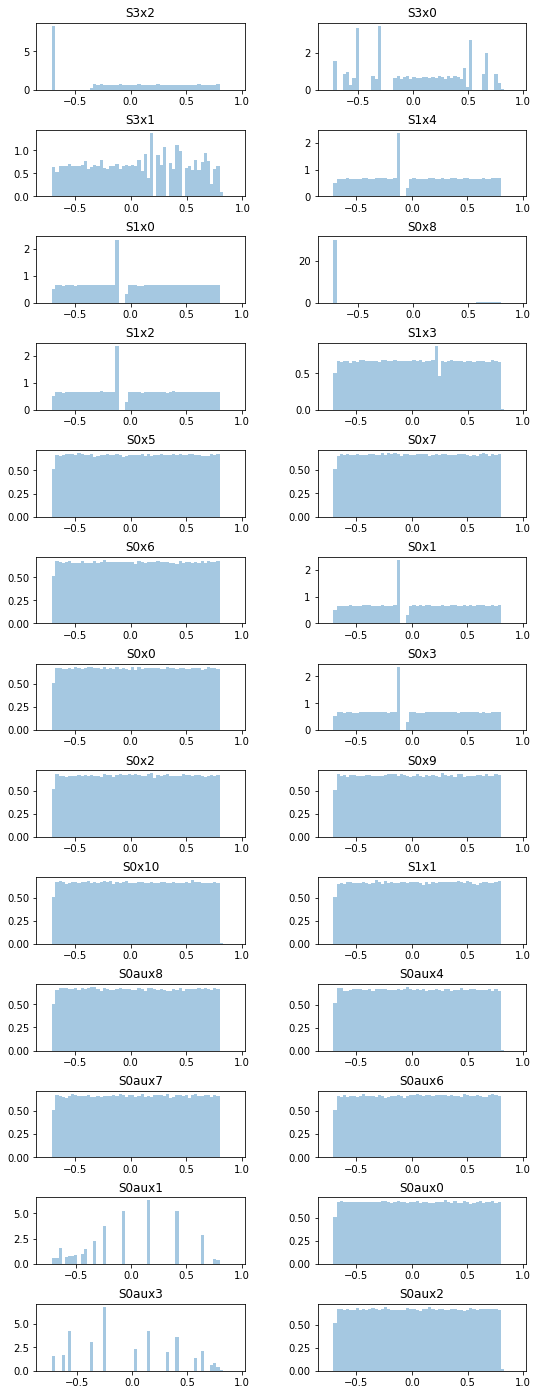

In [7]:
##############################
#####   S C A L I N G  #######
##############################

# We want to scale. The output of the decoder will be between -1 and 1 due to the chosen activation function. 
# Hence, all features should be scaled to range between -1 and 1
# We use percentile scaling. Maybe other methods are more optimal

SCALING           = True
SCALE_BY_CORR_PID = False


if SCALING:
    if SCALE_BY_CORR_PID:
        # Mike suggested that the ProbNN-mu variable is only scaled by the distribution of 
        # ProbNNmu for the corresponding particle (muon).
        # This way the mean squared error for low values of ProbNNmu doesn't matter as much. 

        #THis is not implemented for AUX variables, yet
        scaling_ar = np.zeros((pids_no[fig_to_corr_pid[0]]  ,1))

        for i_pid, pid in enumerate(fig_to_corr_pid):
            scaling_ar_temp = df.loc[df['pid'] == pid][[var_list[i_pid+1]]]
            #scaling_ar_temp = df[[var_list[i_pid]]]
            scaling_ar_temp = scaling_ar_temp.values
            #print (type(scaling_df_temp))
            #print (scaling_df_temp)
            scaling_ar = np.c_[scaling_ar,scaling_ar_temp]
        #print (scaling_ar)
        scaling_df = pd.DataFrame(scaling_ar, columns=df.columns)
        
        print (" S C A L I N G --- D F ")
        print_features_histograms(df, scaling_df, save_filename="unscaled_distribs.png", normed=False)
        
        print ("--"*100)


    data_MC    = df[vars_list_MC].copy().values
    data_input = df[vars_list_input].copy().values
    data_aux   = df[vars_list_aux].copy().values
    

    #Scaling, so that output is uniform. I wrote this package
    import FunctionScaler
    fs = FunctionScaler.FunctionScaler(FunctionScaler.TransformedFunction_Uniform(-0.7,.8), downplay_outofbounds_lower_n_range=None, downplay_outofbounds_upper_n_range=None, downplay_outofbounds_lower_set_point=None, downplay_outofbounds_upper_set_point= None) # calling the normal function by name
    fs_aux = FunctionScaler.FunctionScaler(FunctionScaler.TransformedFunction_Uniform(-0.7,.8), downplay_outofbounds_lower_n_range=None, downplay_outofbounds_upper_n_range=None, downplay_outofbounds_lower_set_point=None, downplay_outofbounds_upper_set_point= None) # calling the normal function by name

    
    
    
    if SCALE_BY_CORR_PID: 
        fs.fit(scaling_df.values[:,1:])
    else                : 
        #fs.fit(df.values[:,1:])
        if "prec" in TYPE:
            fs.fit(data_input)
            fs_aux.fit(data_aux)
        else:
            #It takes a long time to fit the scaling. We don't need a superprecise scaling, so use only 10% of the data
            fs.fit(data_input[:(len(data_input)/10), :]) #Train the transform on 10% of the data
            fs_aux.fit(data_aux[:(len(data_aux)/10), :]) #Train the transform on 10% of the data
        
    scaled_data_input = fs.transform(data_input)
    scaled_data_aux = fs_aux.transform(data_aux)

    if SCALE_BY_CORR_PID: 
        scaled_scaling_features = fs.transform(scaling_df.values[:,1:])
        scaled_scaling_features = np.c_[scaling_df.values[:,0],scaled_scaling_features]
        scaled_scaling_features_df = pd.DataFrame(scaled_scaling_features, columns=scaling_df.columns)

    scaled_features = np.c_[data_MC,scaled_data_input, scaled_data_aux]
    scaled_features_df = pd.DataFrame(scaled_features, index=df.index, columns=vars_list_MC+vars_list_input+vars_list_aux)
    scaled_features_df.head()
    
    
    
    
    print (" S C A L E D --- D F ")
    
    #Display histograms of scaled features
    if SCALE_BY_CORR_PID:
        print_features_histograms(scaled_features_df[vars_list_input+vars_list_aux],scaled_scaling_features_df[vars_list_input+vars_list_aux], save_filename="scaled_distribs.png", normed=False)
    else:
        print_features_histograms(scaled_features_df[vars_list_input+vars_list_aux], None, save_filename="scaled_distribs.png", normed=True)
    
    df= scaled_features_df 
    


In [8]:
# Dividing into Training, Testing and Validation samples
training_frac = 0.70
val_frac      = 0.20


n_train = int(n_samples*training_frac)
n_val = int(n_samples*val_frac) 
n_test = int(n_samples*(1-training_frac-val_frac))

print ("Nb train exmaples " + str(n_train) )
print ("Nb val exmaples " + str(n_val) )
print ("Nb test exmaples " + str(n_test) )

Nb train exmaples 1741359
Nb val exmaples 497531
Nb test exmaples 248765


/usr/local/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


(2238891, 18) (2238891, 8) (2238891, 1)
(248766, 18) (248766, 8) (248766, 1)
encoding_dim :  1
Epoch 00013: early stopping
248766/248766 [==============================] - 4s 16us/step



encoding_dim :  3
Epoch 00024: early stopping
248766/248766 [==============================] - 4s 18us/step



encoding_dim :  6
Epoch 00009: early stopping
248766/248766 [==============================] - 4s 18us/step



encoding_dim :  9
Epoch 00026: early stopping
248766/248766 [==============================] - 5s 21us/step



encoding_dim :  12
Epoch 00035: early stopping
248766/248766 [==============================] - 5s 19us/step



encoding_dim :  15
Epoch 00013: early stopping
248766/248766 [==============================] - 5s 21us/step



encoding_dim :  18
Epoch 00025: early stopping
248766/248766 [==============================] - 6s 25us/step





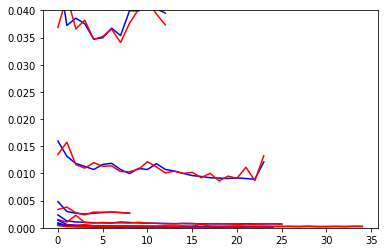

In [9]:
#Do the training 
l_encoding_dim = [1,3,6,9,12,15,18]

if "dummy" in TYPE: l_encoding_dim = [9]

l_score = []

#n_layers = 3; thickness =2 #Unopt
n_layers = 4; thickness =6 #Manually optimised. However, architecture should be optimised


name_arch = "{}h_nodrop_aux".format(n_layers)
train, test = train_test_split(df, random_state=42,train_size=training_frac+val_frac)


        
train_input = train[vars_list_input].copy().values
train_aux   = train[vars_list_aux].copy().values
train_MC    = train[vars_list_MC].copy().values

test_input = test[vars_list_input].copy().values
test_aux   = test[vars_list_aux].copy().values
test_MC    = test[vars_list_MC].copy().values


if train_aux.shape[1]==0: 
    train_aux = np.ones((train_input.shape[0], 2))
    
if test_aux.shape[1]==0: 
    test_aux = np.ones((test_input.shape[0], 2))
    
print (train_input.shape, train_aux.shape, train_MC.shape)
print (test_input.shape, test_aux.shape, test_MC.shape)


nb_epoch = 50
batch_size = 50


early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=3, mode='min')
#tensorboard = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True) you can try to run this visualization

save_decoded_dict = {}
save_encoded_dict = {}
    
for encoding_dim in l_encoding_dim:
    print ("encoding_dim : ", encoding_dim)

    autoencoder, encoder, decoder = create_autoencoder_aux(train_input.shape[1], encoding_dim, n_aux_features=train_aux.shape[1], n_layers=n_layers, thickness=thickness)

    history = autoencoder.fit([train_input, train_aux], train_input,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    verbose=0,
                    validation_split=val_frac/(training_frac+val_frac),
                    callbacks =[early_stopping]
                    )

    score = autoencoder.evaluate([test_input, test_aux], test_input, batch_size=batch_size)
    #print ("\n\nscore : ", score)
    l_score.append(score)

    encoded_test = encoder.predict([test_input, test_aux])
    decoded_test = decoder([encoded_test, test_aux, 0])[0] #test mode = 0
    #print_features_histograms(pd.DataFrame(decoded_test), target=pd.DataFrame(test_input))

    save_decoded_dict[encoding_dim] = decoded_test.astype(np.float64)
    save_encoded_dict[encoding_dim] = encoded_test.astype(np.float64)

    #plt.clf()
    plt.plot(history.history['loss'], "b")
    plt.plot(history.history['val_loss'], "r")
    plt.ylim(0, 0.04)
    #plt.xlim(0, 40)
    print ("\n\n")




In [10]:
#Save what you want to retain to this dictionary
retain_dict = {}
retain_dict['save_decoded_dict']= save_decoded_dict
retain_dict['save_encoded_dict'] =save_encoded_dict
retain_dict['test_input']= test_input.astype(np.float64)
retain_dict['test_aux'] = test_aux.astype(np.float64)
retain_dict['test_MC'] = test_MC
retain_dict['l_score'] = l_score
retain_dict['vars_list_input'] = vars_list_input


In [11]:
retain_dict['test_input_dec'] = fs.invtransform(test_input.astype(np.float64))
retain_dict['test_aux_dec'] = fs_aux.invtransform(test_aux.astype(np.float64))

save_decoded_dict_dec = {}
for encoding_dim in save_decoded_dict:
    save_decoded_dict_dec[encoding_dim] = fs.invtransform(save_decoded_dict[encoding_dim].astype(np.float64))

retain_dict['save_decoded_dict_dec'] = save_decoded_dict_dec

In [12]:
pickle.dump( retain_dict, open( "retain_dict_{}.p".format(TYPE), "wb" ) )

In [13]:
#Visualise the model part I
from keras.utils import plot_model
plot_model(autoencoder, to_file='model.png')

In [14]:
#Visualise the model part II
from keras.utils.vis_utils import plot_model
plot_model(autoencoder, to_file='model_plot.png', show_shapes=True, show_layer_names=False)